# 학습내용

1. GGUF 모델 변환의 필요성
2. GGUF 모델 성능 테스트
3. GUFF 모델 변환 하기
4. Benchmark Tool로 성능 테스트
5. GGUF 포맷의 한계점
6. GGUF 모델 허깅페이스에 배포하기

# 1. GGUF 모델 변환의 필요성
- 모델 변환을 왜 해야하는지에 대해서 이해해 봅시다.

### llama.cpp 라이브러리 소개

- 모델변환이 왜 필요한지 살펴보기 전, llama.cpp 라이브러리부터 알아봅시다.


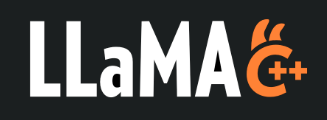

- llama.cpp는 C언어와 C++로 만들어진 **고성능 추론 Library**입니다!






- 반드시 써야하는 건 아닙니다!
  - 파인튜닝하고, 추론 테스트 할때는 PyTorch로 하면 충분합니다!
  - 연구할 때, 토이 프로젝트를 제작할때는 PyTorch, Transformers Library면 충분합니다!

- 하지만, **추론 서비스를 운영할때는 고성능 llama.cpp 라이브러리를 사용합니다,**
  - 허깅페이스의 Transformer로 추론하는 것보다 더 빠릅니다!
  - Unsloth로 추론하는 것 보다 더 빠릅니다!
  - 메모리를 더 적게 사용하고, 추론 속도가 빨라서 사용합니다!
    - AI 서비스를 운영할때는 추론속도가 빨라야 GPU 부담이 줄어듭니다.

### 모델 변환의 필요성 이해

- llama.cpp를 아주 간단히 소개드렸고, 이제 **왜 모델 변환이 필요한지 천천히 살펴봅시다.**

- 이전 수업에서 허깅페이스에 업로드된 모델을 다운로드 받아서 로드 했습니다.
  - .safetensors 라는 파일을 다운로드 받았었죠.
  - PyTorch가 사용하는 확장자입니다.

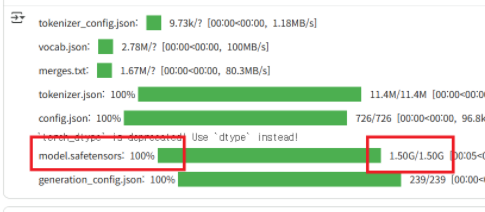

- 이렇게 다운로드 받고, 모델을 로드한 뒤 이런 일들을 해왔습니다.
  - 파인튜닝 or 추론을 해왔었죠.

- 파인튜닝으로 나만의 모델을 만들었습니다!
- 이제 세상 사람들이 내 모델을 사용할 수 있게끔, 챗봇 서비스를 만들 겁니다.

- 챗봇 서비스를 만들었는데, 답변 속도가 너무 느립니다.
  - 사용자들이 너무 느리다고 불만을 가집니다. ㅠㅠ
- GPU를 더 구매해도 되겠지만 너무 비싸요.
  - A100 GPU, 80GB 는 1,500만원이예요


- 방법을 찾았습니다!
  - 추론할때는 허깅페이스의 Transformer 라이브러리 대신 고성능 추론 Library를 사용하면 됩니다.
  - GPU를 추가 구매하지 않아도, 속도를 올릴 수 있습니다!

- 앗!!! llama.cpp 라이브러리는 PyTorch용 모델을 (.safetensor)를 지원하지 않습니다.
  - GGUF포맷 파일인 '.gguf' 파일로된 모델만 지원합니다. ㅠㅠ

- 그럼 내가 만든 모델을 llama.cpp 라이브러리에 쓸 수 있도록 GUFF로 변환해야합니다.

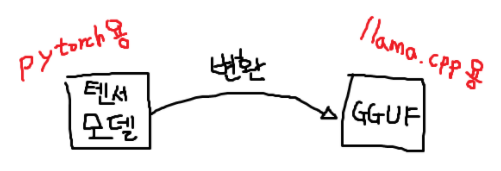

- 여기까지 모델을 변환해야하는 이유였습니다.

### GGUF에 대해서

- llama.cpp에서는 GGUF 포맷만을 지원합니다
  - 이 Library는 PyTorch 모델을 지원하지 않습니다.
  - 고성능 추론을 위해 GGUF 포맷의 모델로 변환을 할 수 밖에 없습니다.

- GGUF 라는 이름은 개발자의 이름을 따서 만들었습니다.
  - llama.cpp 라이브러리 개발자 이름은 Georgi Gerganov (조지 거가노브, 줄여서 GG) 입니다.
  - 그리고 GGUF의 약어는 Georgi Gerganov Unified Format 이죠.

- 이 GGUF 포맷을 따르는 파일은 .gguf 확장자를 갖습니다.
- 이 파일에는 다음과 같은 정보가 다~ 들어있습니다.
  - 텐서 파일 (Weight값)
  - Vocab
  - Model 메타정보
  - (양자화를 했다면, 양자화 정보)
  - 등등

- 이 파일 하나만 있으면 tokenizer, config 등 이런 파일들이 필요없어요.

### 허깅페이스에서 GGUF 구경하기

- 아래 사이트에 접속하여 Quantizations 버튼을 눌러봅시다.
  - https://huggingface.co/Qwen/Qwen3-0.6B
  - 아래 링크에서 양자화된 모델을 확인할 수 있습니다.

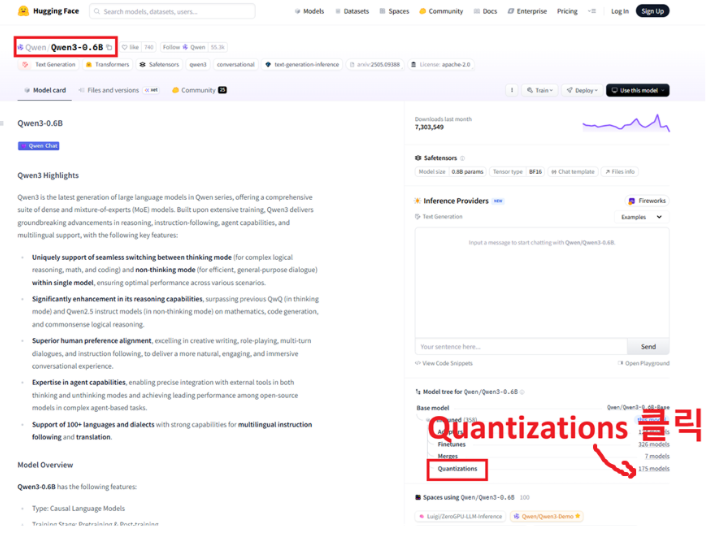

- 친숙한 unsloth가 보이네요.
  - unsloth의 GGUF 모델을 클릭해봅시다.

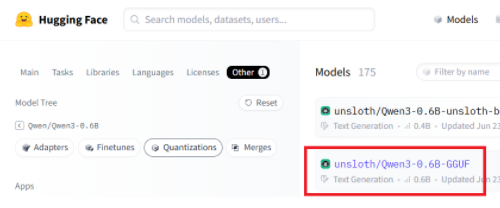

- 이후 Files 탭을 누르면 gguf 파일들을 확인할 수 있습니다.

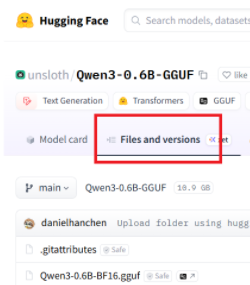

- PyTorch 모델은 .safetensors 파일로 되어있었지만,<br/>
  GGUF로 변환된 모델은 .gguf 파일로 되어있음을 확인할 수 있습니다.

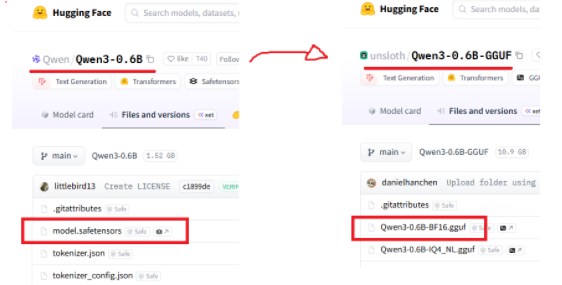

- 파일이 엄청 많습니다.

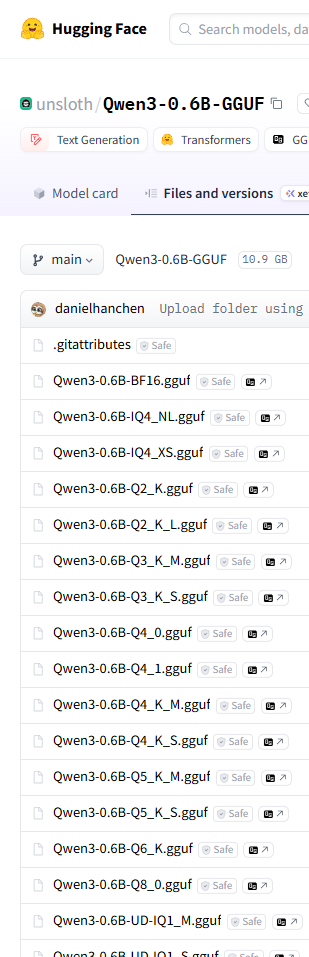


  - 이건 종류별로 하나씩 다 만든겁니다.
    - 아메리카노, 라떼, 프라페치노... 각각 동작되는 모델입니다.
    - **.gguf 파일 하나만 있으면 추론이 잘 됩니다.**
  - BF16 : 양자화 없는 원본
  - IQ : 더 정밀하고 손실이 적은 4bit 양자화
  - Q2, Q3, Q4, Q6.. = 양자화 bit 수
  - 그 뒤에 옵션은 양자화 세부 옵션들 (K_L, K_M, K_S)
- 이중에서 뭘 쓸까요?
  - llama.cpp 라이브러리가 가장 권장 권장하는 옵션은 **Q4_K_M** 입니다. 이걸 사용하면 됩니다.
  
  

# 2. GGUF 모델 성능 테스트
- GGUF 변환 후, 추론 속도가 정말 좋아지는지 확인해봅니다.


### GGUF 파일 추론 테스트
- llama.cpp 라이브러리를 사용하여 추론을 해봅시다.
- C++ Library의 Python 래퍼 가 있습니다.
  - llama-cpp-python 입니다.
    - 아래 설치 명령어는 GPU 옵션이 켜있는 패키지를 다운 받는 명령어입니다.
    - CUDA 12.1 버전은 CUDA 12.4 버전과 호환이 잘 됩니다.

In [1]:
%%capture
!pip install llama-cpp-python --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu121
!pip install huggingface_hub

- 이후 GGUF 모델을 다운로드합니다.

In [2]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="unsloth/Qwen3-0.6B-GGUF",
    filename="Qwen3-0.6B-BF16.gguf" # 양자화 안된 gguf
    #filename="Qwen3-0.6B-Q4_K_M.gguf" # 4bit 양자화 된 gguf
)
print("모델 다운로드 완료:", model_path)

Qwen3-0.6B-BF16.gguf:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

모델 다운로드 완료: /root/.cache/huggingface/hub/models--unsloth--Qwen3-0.6B-GGUF/snapshots/50968a4468ef4233ed78cd7c3de230dd1d61a56b/Qwen3-0.6B-BF16.gguf


- 모델을 로드합니다.

In [3]:
from llama_cpp import Llama

llm = Llama(
    model_path=model_path, # 다운로드한 GGUF 파일 경로
    n_gpu_layers=-1, # -1 : gpu에 모든 Layer 로드
    verbose=False, # 추론시 로그 출력 OFF
)


llama_context: n_ctx_per_seq (512) < n_ctx_train (40960) -- the full capacity of the model will not be utilized


- 추론 시작!

In [4]:
import time, re

def qwen_prompt(user_text, system_text):
    return f"<|im_start|>system\n{system_text}<|im_end|>\n<|im_start|>user\n{user_text}<|im_end|>\n<|im_start|>assistant\n"

user_text = "좋아하는 음식과 특징을 말해줘"
print(f"사람 : {user_text}")

system_text = "짧게 단답형으로 대답해"
prompt = qwen_prompt(user_text, system_text)

def invoke():
    start = time.time() # 시간측정 시작
    response = llm(prompt, max_tokens=512, temperature=0.7)
    elapsed = time.time() - start # 시간측정 끝

    # 결과 저장
    result = response["choices"][0]["text"].split("</think>")[-1].strip()

    print(f"AI : {result}")
    print(f"추론시간 : ⏱ {elapsed:.2f}s")

    num_tokens = len(result.replace(" ", ""))
    return (elapsed, num_tokens)

acc_elapsed = 0.0
acc_tokens = 0
limit_tokens = 1000
while True:
  elapsed, num_tokens = invoke()
  acc_elapsed = acc_elapsed + elapsed
  acc_tokens = acc_tokens + num_tokens

  print(f"누적 토큰 수: {acc_tokens} / {limit_tokens}")
  print()

  # 생성된 예상 토큰수가 1000개 넘어가면 종료
  if acc_tokens > limit_tokens :
    break

tps = acc_tokens / acc_elapsed

print(f"🧮 예상 토큰 수: {acc_tokens}")
print(f"⚡ 초당 처리 속도: {tps:.2f} tokens/sec")

사람 : 좋아하는 음식과 특징을 말해줘
AI : 내가 좋아하는 음식은 고구마 치즈 카페인 카페소입니다. 특징은 풍부한 훌륭한 치즈와 신선한 야채 맛이 특이합니다.
추론시간 : ⏱ 2.63s
누적 토큰 수: 49 / 1000

AI : 어떤 음식을 좋아하는지 알려드세요! 예를 들어, 카페인과 훌라, 그릴, 또는 포스트메뉴 등이 좋아요. 특징은 보통 맛이나 재료나 시 느끼기 등입니다. 알려주시면 더 유용하게 대답해 드릴 수 있습니다. 😊
추론시간 : ⏱ 3.07s
누적 토큰 수: 135 / 1000

AI : 망치하는 음식: 피자  
특징: 빵, 사탕, 토마토, 코너.
추론시간 : ⏱ 1.60s
누적 토큰 수: 160 / 1000

AI : 좋아하는 음식: 치즈케이크  
특징: 맛있고 건강하며, 풍부한 단백질과 섬유질로 구성되어 있습니다.
추론시간 : ⏱ 1.91s
누적 토큰 수: 204 / 1000

AI : 나는 주식이 좋아요. 주식은 풍부한 맛과 세련된 예술성을 특징으로합니다.
추론시간 : ⏱ 1.82s
누적 토큰 수: 236 / 1000

AI : 좋아하는 음식: 오렌지를 좋아해, 썬베리와 콩, 그리고 훈련에 맞춘 요리가 특징입니다.
추론시간 : ⏱ 2.27s
누적 토큰 수: 274 / 1000

AI : 내가 좋아하는 음식은 [예: 훈련용 음식]이며, 특징은 [특히] [특히]입니다. (예시: "피자"로 답변하고, "영양ครบ"이나 "시럽 풍부" 등 특징을 설명해 드릴 수 있습니다.)
추론시간 : ⏱ 2.83s
누적 토큰 수: 355 / 1000

AI : 내가 좋아하는 음식은 **아스프랑디**입니다. 그 음식은 풍부한 양파와 토마토가 포함되어 있어 풍부한 맛이 특징입니다. 또한, 외로운 풍부함과 풍부한 맛이 매력이 되는 요소입니다.
추론시간 : ⏱ 2.23s
누적 토큰 수: 434 / 1000

AI : 좋아하는 음식: **피자**  
특징: **양념이 많고, 풍부한 맛**.
추론시간 : ⏱ 1.65s
누적 토큰 수: 466 / 1000

AI : 좋은 

### PyTorch 모델 추론 vs GGUF 모델 추론 속도 비교

- .gguf 모델은 배포용으로 사용된다고 배웠습니다.
  - C++ 기반 추론 Library인 llama.cpp 를 쓰기 위함입니다.

- 얼마나 성능차이가 나는지 확인해봅시다!
  - GGUF 성능이 더 빠른것을 확인할 수 있습니다.

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
model_name = "Qwen/Qwen3-0.6B"

# 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.bfloat16, #BF16
    device_map="auto"
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [6]:
import time, re
user_text = "좋아하는 음식과 특징을 말해줘"
print(f"사람 : {user_text}")

system_text = "짧게 단답형으로 대답해"

messages = [
    {"role": "system", "content": system_text},
    {"role": "user", "content": user_text}
]

# Qwen 템플릿으로 변경
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
)

# 토크나이저
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)


def invoke():
    start = time.time() # 시간측정 시작
    generated_ids = model.generate(**model_inputs, max_new_tokens=512)
    elapsed = time.time() - start # 시간측정 끝

    # 결과 저장
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()
    result = tokenizer.decode(output_ids[0:], skip_special_tokens=True).strip("\n")

    print(f"AI : {result}")
    print(f"추론시간 : ⏱ {elapsed:.2f}s")

    num_tokens = len(result.replace(" ", ""))
    return (elapsed, num_tokens)

acc_elapsed = 0.0
acc_tokens = 0
limit_tokens = 1000
while True:
  elapsed, num_tokens = invoke()
  acc_elapsed = acc_elapsed + elapsed
  acc_tokens = acc_tokens + num_tokens

  print(f"누적 토큰 수: {acc_tokens} / {limit_tokens}")
  print()

  # 생성된 예상 토큰수가 1000개 넘어가면 종료
  if acc_tokens > limit_tokens :
    break

tps = acc_tokens / acc_elapsed

print(f"🧮 예상 토큰 수: {acc_tokens}")
print(f"⚡ 초당 처리 속도: {tps:.2f} tokens/sec")

사람 : 좋아하는 음식과 특징을 말해줘
AI : - 좋아하는 음식: 채식주의자 선호의 채소류(감자, 달걀, 채소류)  
- 특징: 과부자리, 맛있고, 영양豐富
추론시간 : ⏱ 3.90s
누적 토큰 수: 48 / 1000

AI : 좋은 음식: 피자 – 특징: 맛있고 풍부한 감각.
추론시간 : ⏱ 1.23s
누적 토큰 수: 68 / 1000

AI : - **아침식사**: 훌륭한 채소와 양념이 좋아요.
추론시간 : ⏱ 1.19s
누적 토큰 수: 91 / 1000

AI : 좋은 음식은 주로 훌륭한 풍미, 맛, 재료, 재료, 요리법, 조리 시간, 와이프, 음식, 스타일, 풍요로움, 다양성, 풍부함, 풍진, 풍유, 풍미, 풍요, 풍부, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, 풍진, 풍유, �
추론시간 : ⏱ 25.12s
누적 토큰 수: 413 / 1000

AI : 좋은 음식은 **고기**이고, 그 특징은 **가벼운 맛**입니다.
추론시간 : ⏱ 1.21s
누적 토큰 수: 443 / 1000

AI : 좋은 음식: 쑤어치 케이크  
특징: 와인, 감, 훌륭한 구성.
추론시간 : ⏱ 1.76s
누적 토큰 수: 469 / 1000

AI : - **좋은 음식**: 채식어, 쇼크, 콤보, 쿠피, 콩비 등.  
- **특징**: 맛있고, 맥이 잘, 맛이 잘, 맥이 잘.
추론시간 : ⏱ 3.25s
누적 토큰 수: 521 / 1000

A

### 실험 결과

- GGUF가 확실히 빠르게 토큰을 생성해냅니다.
- 추론 안정성도 차이가 있었습니다.
  - GGUF는 한번에 결과가 잘 나오는데, PyTorch는 4번중 1번 실행시 무한루프에 빠지곤 했습니다.
- 생성된 문장의 품질은 비교하지 못했습니다.
  - 이는 LLM as a judge 를 통해 평가할 수 있습니다.
- 역시 배포는 GGUF로 해야되겠습니다.

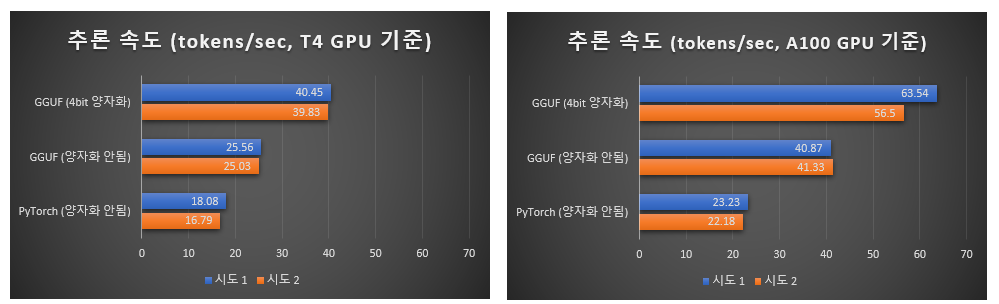

# 3. GUFF 모델 변환하기


### 변환할 모델 준비

- 이번 챕터에서는 PyTorch 모델을 직접 GGUF로 변환 후 추론까지 해보겠습니다.
- 먼저 모델을 로드 후, 파일로 저장하겠습니다.

In [3]:
# 모델 저장
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen3-0.6B"

# 모델 다운로드 & 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


# 이후 파인튜닝을 다 했다고 가정합니다.
# 파인튜닝 코드 시작
# ...~
# 파인튜닝 코드 끝


# 파인튜닝 완료된 모델 저장 (5분 소요)
print('모델 저장중...')
save_path = "./my_trained_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("모델 저장 완료:", save_path)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

모델 저장중...
모델 저장 완료: ./my_trained_model


- 저장이 잘 된것을 확인할 수 있습니다.

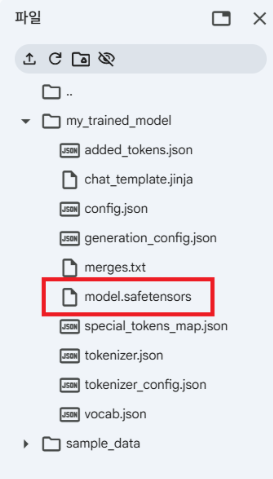

### GGUF 포맷으로 변환

- 이제 .safetensors --> GGUF로 변환을 해야하는데 두 가지 방법이 있습니다.

- 방법1 : llama.cpp 공식 가이드
  1. `git clone https://github.com/ggerganov/llama.cpp` 으로 Clone 받고
  2. convert_hf_to_gguf.py로 GGUF 변환 (BF16)을 하고
  3. 빌드하고 (cmake)
  4. llama-quantize 툴로 4bit 양자화를 한다.

<br/>

- **방법2 : Unsloth 함수 호출**
  1. save_pretrained_gguf() 함수를 호출한다.
      - 내부적으로 위 동작을 수행합니다.
  2. 끝!

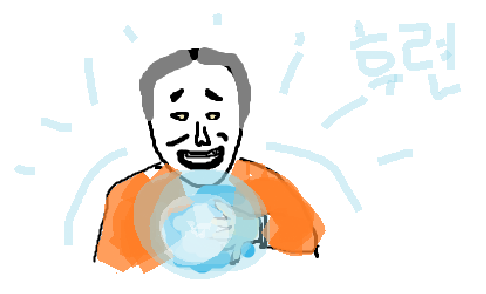

- unsloth 를 설치합시다.

In [2]:
!pip install unsloth

  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (47.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
Found existing installation: pyarrow 22.0.0
Uninstalling pyarrow-22.0.0:
  Successfully uninstalled pyarrow-22.0.0
  Using cached pyarrow-17.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-17.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (39.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

- [Trouble Shooting] 아래는 버전 충돌로 인한 해결책입니다.

In [ ]:
!pip uninstall -y pyarrow
!pip install pyarrow==17.0.0

- 변환합니다!
  - 아래 코드를 실행하면, 16분 정도 걸린다고 로그 메세지가 나옵니다.

In [3]:
from unsloth import FastLanguageModel

# 기존 저장된 모델 경로
model_path = "./my_trained_model"

# GGUF 변환 (오래걸림)
model, tokenizer = FastLanguageModel.from_pretrained(model_path, dtype = None)

# 양자화 후 저장
model.save_pretrained_gguf(
    model_path,
    tokenizer = tokenizer,
    quantization_method = "q4_k_m",
)

print('변환 완료!')

/tmp/ipython-input-1495885337.py:1: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.11: Fast Qwen3 patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Merging model weights to 16-bit format...


/usr/local/lib/python3.12/dist-packages/unsloth_zoo/saving_utils.py:949: UserWarning: Model is not a PeftModel (no Lora adapters detected). Skipping Merge. Please use save_pretrained() or push_to_hub() instead!
  warnings.warn("Model is not a PeftModel (no Lora adapters detected). Skipping Merge. Please use save_pretrained() or push_to_hub() instead!")


Unsloth: Converting to GGUF format...
==((====))==  Unsloth: Conversion from HF to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF f16 might take 3 minutes.
\        /    [2] Converting GGUF f16 to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: Updating system package directories


KeyboardInterrupt: 

- 아래 파일이 생성 되었으면 성공입니다.

image.png

### 생성한 .gguf파일 추론 테스트

- 생성된 파일을 추론테스트 해봅니다.

In [ ]:
from llama_cpp import Llama

# 로컬 파일을 불러옵니다.
model_path = "./my_trained_model.Q4_K_M.gguf"

llm = Llama(
    model_path=model_path, # 다운로드한 GGUF 파일 경로
    n_gpu_layers=-1, # -1 : gpu에 모든 Layer 로드
    verbose=False, # 추론시 로그 출력 OFF
)

llama_context: n_ctx_per_seq (512) < n_ctx_train (40960) -- the full capacity of the model will not be utilized


In [ ]:
def qwen_prompt(user_text, system_text):
    return f"<|im_start|>system\n{system_text}<|im_end|>\n<|im_start|>user\n{user_text}<|im_end|>\n<|im_start|>assistant\n"

user_text = "좋아하는 음식과 특징을 말해줘"
print(f"사람 : {user_text}")

system_text = "짧게 단답형으로 대답해"
prompt = qwen_prompt(user_text, system_text)

response = llm(prompt, max_tokens=512, temperature=0.7)

# 결과 저장
result = response["choices"][0]["text"].split("</think>")[-1].strip()

print(f"AI : {result}")

사람 : 좋아하는 음식과 특징을 말해줘
AI : 내가 좋아하는 음식은 훌륭한피자입니다. 특징은 토마토 토비, 콩, 그리고 햇빛 아래 배우며 느끼는 맛입니다. 🍕✨


- 여기까지 모델 변환을 해보았습니다.
  - 이제 LLM 모델을 파인튜닝을 하신 후, GGUF로 변환 후 추론까지 가능해졌습니다.

# 4. Benchmark Tool로 성능 테스트

### 벤치마크 도구 준비

- 3번 실습에서 unsloth로 GGUF를 수행하면 llama.cpp가 Clone & Build가 됩니다.
- llama.cpp 폴더 안에는 추론 속도를 테스트 할 수 있는 도구가 포함되어있습니다.

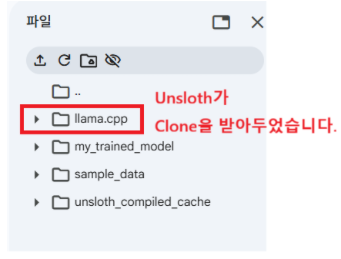

- 벤치마크 툴을 실행을 위해 빌드합니다.
  - 10분 걸립니다.
    - 멈춰있는 것 같지만, 빌드 중입니다.

In [ ]:
%cd llama.cpp
!cmake -B build -DGGML_CUDA=on -DLLAMA_BUILD_TOOLS=ON

[Errno 2] No such file or directory: 'llama.cpp'
/content/llama.cpp
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
CMAKE_BUILD_TYPE=Release
-- Found Git: /usr/bin/git (found version "2.34.1")
-- The ASM compiler identification is GNU
-- Found assembler: /usr/bin/cc
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
-- Warning: ccache not found - consider installing it for faster compilation or disable this warning with GGML_CCACHE=OFF
-- CMAKE_SYSTEM_PROCESSOR: x86_64
-

In [ ]:
!cmake --build build --target llama-bench -j

[  0%] Building CXX object common/CMakeFiles/build_info.dir/build-info.cpp.o
[  0%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml.c.o
[  1%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml.cpp.o
[  1%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml-alloc.c.o
[  1%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-backend.cpp.o
[  1%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-opt.cpp.o
[  3%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/ggml-threading.cpp.o
[  3%] Building C object ggml/src/CMakeFiles/ggml-base.dir/ggml-quants.c.o
[  3%] Building CXX object ggml/src/CMakeFiles/ggml-base.dir/gguf.cpp.o
[  3%] Built target build_info
[  5%] Linking CXX shared library ../../bin/libggml-base.so
[  5%] Built target ggml-base
[  5%] Building C object ggml/src/CMakeFiles/ggml-cpu.dir/ggml-cpu/ggml-cpu.c.o
[  5%] Building CXX object ggml/src/CMakeFiles/ggml-cpu.dir/ggml-cpu/ggml-cpu.cpp.o
[  5%] Building CXX object ggml/src/CMa

### 벤치마크 수행

- 벤치마크 툴을 실행해봅니다.
  - pp512
    - 한번에 512개 토큰 단위로 모델에 입력합니다
    - 이때, 1초에 **입력(인코딩)** 처리 할수 있는 있는 토큰 수를 나타냅니다.
  - tg128
    - 한번에 128개 토큰 단위로 생성합니다.
    - 이때, 1초에 **생성(디코딩)** 할 수 있는 토큰 수를 나타냅니다.

In [ ]:
%cd /content/
!./llama.cpp/build/bin/llama-bench -m ./my_trained_model.Q4_K_M.gguf -p 512 -n 128

/content
ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA L4, compute capability 8.9, VMM: yes
| model                          |       size |     params | backend    | ngl |            test |                  t/s |
| ------------------------------ | ---------: | ---------: | ---------- | --: | --------------: | -------------------: |
| qwen3 0.6B Q4_K - Medium       | 372.65 MiB |   596.05 M | CUDA       |  99 |           pp512 |   16087.03 ± 1041.89 |
| qwen3 0.6B Q4_K - Medium       | 372.65 MiB |   596.05 M | CUDA       |  99 |           tg128 |        336.11 ± 3.99 |

build: 10fcc4129 (6877)


### 벤치마크 결과 분석

- 만약 출력결과가 아래와 같으면, 이렇게 해석합니다.
  - 인코딩 속도 : 초당 16,369개 토큰
  - 디코딩 속도 : 초당 343개 토큰

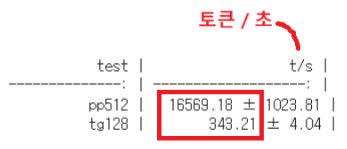

- 이번엔 모델을 더 추가해서 모델별 성능비교를 해봅시다.

In [ ]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="unsloth/Qwen3-0.6B-GGUF",
    filename="Qwen3-0.6B-BF16.gguf", # 양자화 안된 gguf
    local_dir="./"
)

print("모델 다운로드 완료")

모델 다운로드 완료


- 다운로드 받은 모델 성능을 측정하고, 비교해봅시다.
  - 이번엔 양자화가 안된 모델이므로, 성능이 더 낮을 것입니다.

In [ ]:
%cd /content/
!./llama.cpp/build/bin/llama-bench -m ./Qwen3-0.6B-BF16.gguf -p 512 -n 128

/content
ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA L4, compute capability 8.9, VMM: yes
| model                          |       size |     params | backend    | ngl |            test |                  t/s |
| ------------------------------ | ---------: | ---------: | ---------- | --: | --------------: | -------------------: |
| qwen3 0.6B BF16                |   1.11 GiB |   596.05 M | CUDA       |  99 |           pp512 |   15898.72 ± 1154.39 |
| qwen3 0.6B BF16                |   1.11 GiB |   596.05 M | CUDA       |  99 |           tg128 |        171.44 ± 0.31 |

build: 10fcc4129 (6877)


- 이렇게 양자화를 함으로써, 정확한 데이터로 추론 속도를 비교할 수 있었습니다.

- 모델별 성능 비교도 가능하지만, HW 성능 측정도 가능합니다.
  - 한 모델을 기준으로, 여러 장치들을 바꿔가면서 성능측정 할 수 있습니다.
  - 아래 링크를 보시면, Llama 2 7B 기준의 Score 보드입니다.
    - https://github.com/ggml-org/llama.cpp/discussions/15013
      - RTX 5090 GPU가 A100 GPU보다 경량모델의 추론속도가 빠르군요!


- 여기까지 모델의 추론 속도를 정확히 측정하는 방법을 학습했습니다.

# 5. GGUF 포맷의 한계점

### GGUF 포맷의 한계점

- GGUF은 추론 전용 포맷입니다!
  - GGUF로 변환된 모델은 LoRA 등 파인튜닝이 되지 않습니다.
- GGUF는 Transformer 계열 LLM 전용입니다!
  - CNN 기반 모델 사용 불가능합니다.
  - 멀티모달 LLM은 제한적으로 사용 가능합니다.
  - ViT와 같은 이미지 Transformer 모델도 제한적입니다.

<br/>

- GGUF로 양자화가 안되는 모델의 대안은 무엇이 있을까요!?
  - 바로 **TFLite** 입니다.
    - TensorFlow의 Lite 버전 입니다.
    - Google이 만든 경량화된 모델을 위한 프레임워크입니다.
      - PyTorch로 안되니, Tensorflow로 해야죠 ㅎㅎ

### TFLite 의 활용처
  - 임베디드 환경에서 가장 많이 쓰입니다.
    - 임베디드 장치는 tflite만 지원하는 경우가 많습니다.
  - 모바일 환경에서도 쓰입니다.    
    - TensorFlow Lite SDK 를 활용한 iOS / Android App을 만들 수 있습니다.
  - 서버 환경에서도 쓰입니다.
    - llama.cpp를 사용하지 못하는 모델에 사용됩니다.
    - CNN 기반 모델, 멀티모달 Transformer 등 지원합니다.
    - 정확히 사용하고자 하는 모델별로 지원 여부를 확인 후 사용해야합니다!
  - EASY 교안에서는 TFLite를 다루지 않습니다~.

# 6. 모델 배포

### 모델을 허깅페이스의 Repository에 Push하기


- 지금까지 양자화를 하여 배포할 준비를 끝냈으니, 이번 챕터에서는 모델을 배포해보겠습니다.
- 허깅페이스에 접속하여 Model Repository를 생성해주세요.

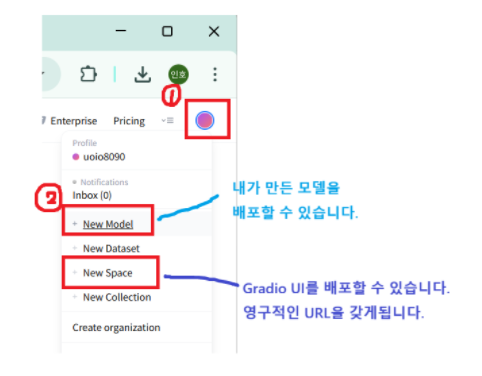

- Public으로 생성합니다.
  - 모델이름은 자유롭게 정합니다.

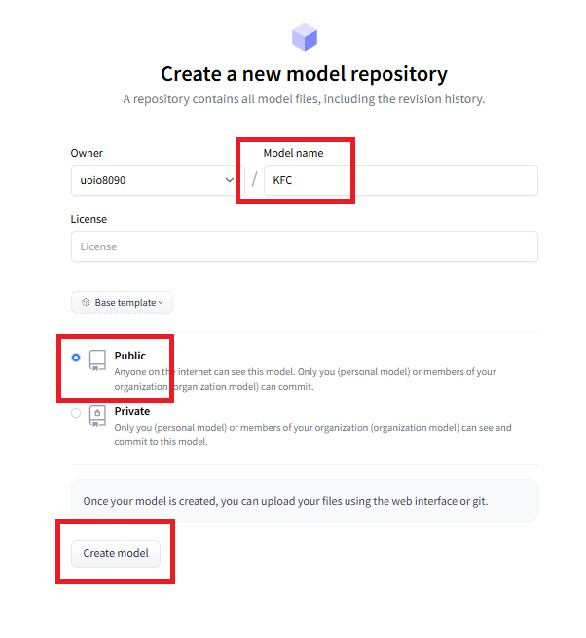

- Model Card에 Push 하는 명령어가 나와있습니다.

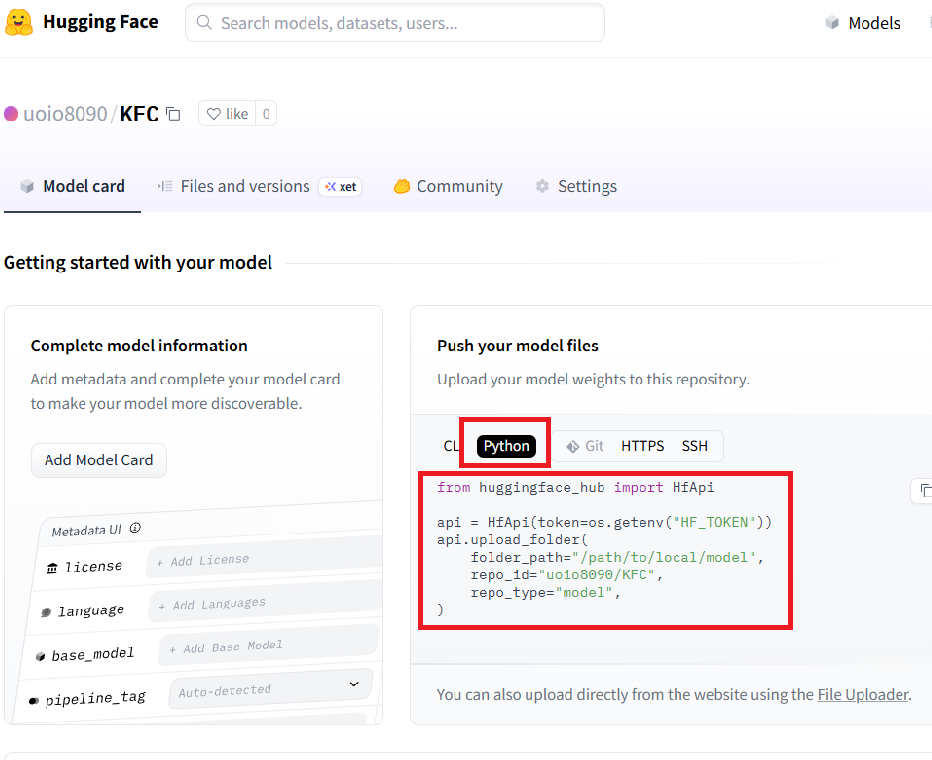

- 허깅페이스 키가 필요합니다. Write 권한으로 생성 해주세요.

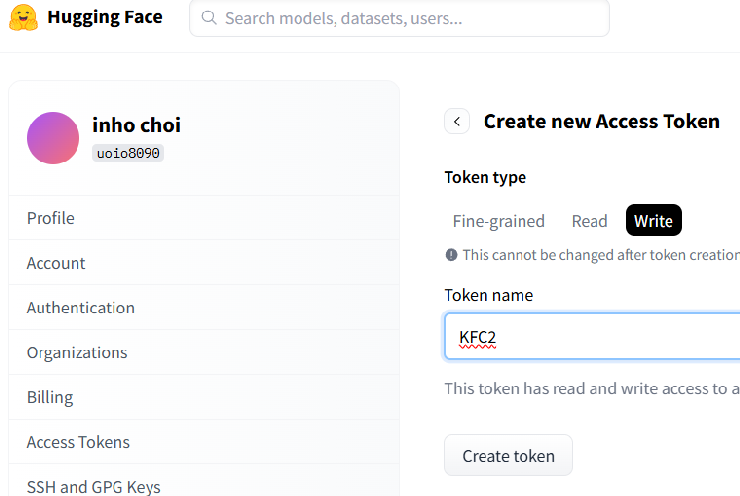

- 아래와 같이 등록해두었습니다.

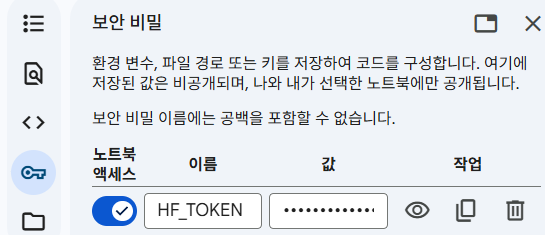

- 아래 코드를 수정하여 Push를 합시다.
  - 본인의 Repository로 수정하여 Push 합니다.

In [ ]:
from huggingface_hub import HfApi
import os

from google.colab import userdata
api = HfApi(token=userdata.get('HF_TOKEN'))

api.upload_file(
    path_or_fileobj="./my_trained_model.Q4_K_M.gguf",  # 로컬 파일 경로
    path_in_repo="my_trained_model.Q4_K_M.gguf",       # HF Hub에서 보일 파일 이름
    repo_id="uoio8090/KFC",                            # 본인 Repo (예: username/repo)
    repo_type="model",                                 # 모델 repo
)

CommitInfo(commit_url='https://huggingface.co/uoio8090/KFC/commit/11e0ea1b61fd40d3bc09eb442d02e51fea120e41', commit_message='Upload my_trained_model.Q4_K_M.gguf with huggingface_hub', commit_description='', oid='11e0ea1b61fd40d3bc09eb442d02e51fea120e41', pr_url=None, repo_url=RepoUrl('https://huggingface.co/uoio8090/KFC', endpoint='https://huggingface.co', repo_type='model', repo_id='uoio8090/KFC'), pr_revision=None, pr_num=None)

- Push가 완료 되었습니다.

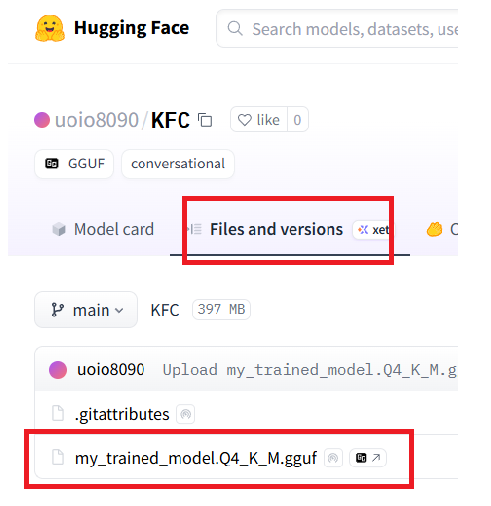

- 다음 실습을 위해 Model Repository 이름을 메모해주세요.

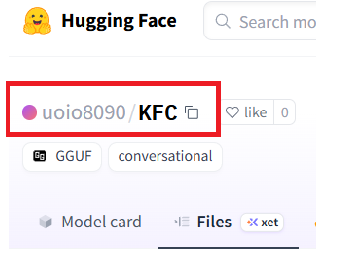

### Push한 모델 동작 테스트

- 아래 코드가 잘되는지 확인합니다.
  - 본인의 Repo 명과 GGUF 파일명으로 바꿔주세요


In [ ]:
import gradio as gr
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

# ========================================
# 모델 다운로드
# ========================================
REPO_ID = "uoio8090/KFC"                     # Hugging Face Repo
MODEL_FILE = "my_trained_model.Q4_K_M.gguf"  # GGUF 파일명

model_path = hf_hub_download(repo_id=REPO_ID, filename=MODEL_FILE)

# ========================================
# 모델 로드
# ========================================
llm = Llama(
    model_path=model_path, # 다운로드한 GGUF 파일 경로
    n_gpu_layers=-1, # -1 : gpu에 모든 Layer 로드
    verbose=False, # 추론시 로그 출력 OFF
)

# ========================================
# 추론 함수 정의
# ========================================
def qwen_prompt(user_text, system_text):
    return f"<|im_start|>system\n{system_text}<|im_end|>\n<|im_start|>user\n{user_text}<|im_end|>\n<|im_start|>assistant\n"

def invoke(prompt):
    response = llm(prompt, max_tokens=512, temperature=0.7)
    result = response["choices"][0]["text"].split("</think>")[-1].strip()
    return result

def chat(message, history):
    system_text = "친절하게 대답해"
    prompt = qwen_prompt(message, system_text)
    answer = invoke(prompt)

    history = history + [
        {"role": "user", "content": message},
        {"role": "assistant", "content": answer}
    ]
    return "", history

# ========================================
# Gradio Blocks 기반 UI
# ========================================
with gr.Blocks(title="LangChain Agent Chat") as demo:
    gr.Markdown("## 🤖 LangChain Agent Chat\nLangChain Agent가 도구를 활용해 답변합니다.")

    chatbot = gr.Chatbot(
        height=300,
        label="대화창",
        type="messages"
    )

    msg = gr.Textbox(
        label="💬 질문을 입력하세요",
        placeholder="예: 오늘 서울 날씨 어때?",
    )

    # 엔터 누르면 chat 함수 호출
    msg.submit(chat, inputs=[msg, chatbot], outputs=[msg, chatbot])

demo.launch(share=True)

llama_context: n_ctx_per_seq (512) < n_ctx_train (40960) -- the full capacity of the model will not be utilized


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9b0cf108b2466d2b33.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 7. 미션

다음 미션을 수행하고 평생 링크 URL을 MM 으로 남겨주세요!
  1. Qwen3-0.6B 모델을 파인튜닝 (제주도 사투리 파인튜닝)
  2. 4 bit 양자화 (GGUF)
  3. 허깅페이스에 모델 Push하기
  4. Gradio로 나만의 AI Service 제작!
  5. 성공하신 분은 URL을 MM으로 제출해주세요~